In [2]:
''' mainly used to make sure that C nmr works better than HSQC'''
# pip install umap-learn
import umap
import torch
torch.set_printoptions(precision=10)

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from models.optional_input_ranked_transformer import OptionalInputRankedTransformer
from datasets.optional_2d_folder_dataset import OptionalInputDataModule
from datasets.hsqc_folder_dataset import FolderDataModule
import yaml
from pytorch_lightning.loggers import TensorBoardLogger
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets import dataset_utils
from datasets.dataset_utils import specific_radius_mfp_loader

            


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np 
import pickle 
import time


In [4]:
# load model 

model_path = Path("/root/MorganFP_prediction/reproduce_previous_works/weird_H_and_tautomer_cleaned/flexible_models_best_FP/r0_r2_FP_trial_2/")

hyperpaerameters_path = model_path / "hparams.yaml"

# checkpoint_path = model_path / "checkpoints/epoch=14-step=43515.ckpt"


with open(hyperpaerameters_path, 'r') as file:
    hparams = yaml.safe_load(file)
    
FP_building_type = hparams['FP_building_type'].split("_")[-1]
only_2d = not hparams['use_oneD_NMR_no_solvent']
print(FP_building_type)
print(int(hparams['FP_choice'].split("_")[-1][1:]))
specific_radius_mfp_loader.setup(only_2d=only_2d,FP_building_type=FP_building_type)
specific_radius_mfp_loader.set_max_radius(int(hparams['FP_choice'].split("_")[-1][1:]), only_2d=only_2d)


del hparams['checkpoint_path'] # prevent double defition of checkpoint_path
hparams['use_peak_values'] = False




Normal
2


In [ ]:
checkpoint_path = model_path / "checkpoints/epoch=42-all_inputs.ckpt"

model = OptionalInputRankedTransformer.load_from_checkpoint(checkpoint_path, **hparams)


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


In [ ]:
datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], batch_size=1, parser_args=hparams)
datamodule.setup("predict")
datamodule.setup("fit")

loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = \
    datamodule.predict_dataloader()

train_loader = datamodule.train_dataloader()

val_loader_all_input = datamodule.val_dataloader()[0]
# datamodule.setup("test")
# loader_only_hsqc = datamodule.test_dataloader()
    
# model=model.to("cuda")

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
all_testset_tensors = []
for idx, batch in enumerate(loader_all_inputs):
       
    inputs, (smiles_chemical_name) = batch
    # print(inputs, smiles_chemical_name)
    
    batch[0] = batch[0].to("cuda")
    representation = model.predict_step(batch, idx, dataloader_idx=0, return_representations=True)
    all_testset_tensors.append(representation[0, 0, :]) # representation is shape [1*sequence_len*hidden_size], we only need cls token

In [ ]:
import tqdm
all_trainset_tensors = []
# for idx, batch in tqdm.tqdm(enumerate(train_loader)):
       
#     inputs, _ = batch
#     # print(inputs, smiles_chemical_name)
    
#     batch[0] = batch[0].to("cuda")
#     representation = model.predict_step(batch, idx, dataloader_idx=0, return_representations=True)
#     all_trainset_tensors.append(representation[:, 0, :]) # representation is shape [1*sequence_len*hidden_size], we only need cls token

In [ ]:
all_valset_tensors = []
for idx, batch in enumerate(val_loader_all_input):
       
    inputs, _ = batch
    # print(inputs, smiles_chemical_name)
    
    batch[0] = batch[0].to("cuda")
    representation = model.predict_step(batch, idx, dataloader_idx=0, return_representations=True)
    all_valset_tensors.append(representation[0, 0, :]) # representation is shape [1*sequence_len*hidden_size], we only need cls token

In [ ]:
import torch.nn.functional as F
import os
hsqc_mode = None

def get_delimeter(delimeter_name):
    match delimeter_name:
        case "HSQC_start":
            return torch.tensor([-1,-1,-1]).float()
        case "HSQC_end":
            return torch.tensor([-2,-2,-2]).float()
        case "C_NMR_start":
            return torch.tensor([-3,-3,-3]).float()
        case "C_NMR_end":
            return torch.tensor([-4,-4,-4]).float()
        case "H_NMR_start":
            return torch.tensor([-5,-5,-5]).float()
        case "H_NMR_end":
            return torch.tensor([-6,-6,-6]).float()
        case "solvent_start":
            return torch.tensor([-7,-7,-7]).float()
        case "solvent_end":
            return torch.tensor([-8,-8,-8]).float()
        case "ms_start":
            return torch.tensor([-12,-12,-12]).float()
        case "ms_end":
            return torch.tensor([-13,-13,-13]).float()
        case _:
            raise Exception(f"unknown {delimeter_name}")

def unpack_inputs(inputs):
    for i, vals in enumerate(inputs[0]):
        # if vals is [-1, -1, -1]
        if vals[0]==-1 and vals[1]==-1 and vals[2]==-1:
            hsqc_start=i+1
        elif vals[0]==-2 and vals[1]==-2 and vals[2]==-2:
            hsqc_end=i
        elif vals[0]==-3 and vals[1]==-3 and vals[2]==-3:
            c_nmr_start=i+1
        elif vals[0]==-4 and vals[1]==-4 and vals[2]==-4:
            c_nmr_end=i
        elif vals[0]==-5 and vals[1]==-5 and vals[2]==-5:
            h_nmr_start=i+1
        elif vals[0]==-6 and vals[1]==-6 and vals[2]==-6:
            h_nmr_end=i
            
    hsqc = inputs[0,hsqc_start:hsqc_end]
    c_tensor = inputs[0,c_nmr_start:c_nmr_end,0]
    h_tensor = inputs[0,h_nmr_start:h_nmr_end,0]
    return hsqc, c_tensor, h_tensor
 
 
def build_input(compound_dir, mode = hsqc_mode):
    print("\n\n")
    print(compound_dir.split("/")[-1])
    print("\n")
    def load_2d():
        return torch.tensor(np.loadtxt(os.path.join(compound_dir, "HSQC.txt"), delimiter=",")).float()
    def load_1d(nmr):
        vals = np.loadtxt(os.path.join(compound_dir, f"{nmr}.txt"), delimiter=",")
        vals = torch.tensor(np.unique(vals)).float()
        return F.pad(vals.view(-1, 1), (0, 2), "constant", 0)
    
    hsqc = load_2d()
    if hsqc is not None:
        hsqc[:,[0,1]] = hsqc[:,[1,0]]
        if mode == "no_sign":
            hsqc = torch.abs(hsqc)
        elif mode == "flip_sign":
            hsqc[:,2] = -hsqc[:,2]
    c_tensor = load_1d("C")
    h_tensor = load_1d("H")
    inputs = torch.vstack([
                    get_delimeter("HSQC_start"),  hsqc,     get_delimeter("HSQC_end"),
                    get_delimeter("C_NMR_start"), c_tensor, get_delimeter("C_NMR_end"), 
                    get_delimeter("H_NMR_start"), h_tensor, get_delimeter("H_NMR_end"),
                    ])   
    with open(os.path.join(compound_dir, "mw.txt"), 'r') as file:
        # Read the content of the file
        content = file.read()
        # Convert the content to a float
        mw = float(content)
    mol_weight = torch.tensor([mw,0,0]).float()
    # print(inputs)
    # print(hsqc, c_tensor, h_tensor)
    return torch.vstack([inputs, get_delimeter("ms_start"), mol_weight, get_delimeter("ms_end")])



In [ ]:
import os
os.listdir("/root/MorganFP_prediction/inference_data/testing_compounds")

['new_compound_B1',
 'Kavaratamide A',
 'new_compound_A',
 'methyl_beta-D-glucopyranoside',
 'new_compound_B2']

In [ ]:
compound_name = ['new_compound_B1',
                'Kavaratamide A',
                'new_compound_A',
                # 'methyl_beta-D-glucopyranoside',
                'new_compound_B2']
new_molecules = []
for compound_name in compound_name:
    compound_dir = f"/root/MorganFP_prediction/inference_data/testing_compounds/{compound_name}"
    mode = None#"flip_sign"
    inputs = build_input(compound_dir, mode=mode)
    inputs = inputs.unsqueeze(0).to("cuda")
    new_molecules.append(model(inputs, return_representations=True)[0,0] )




new_compound_B1





Kavaratamide A





new_compound_A





new_compound_B2




In [ ]:
new_molecules[0].shape

(384,)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

train_checkpoint = len(all_trainset_tensors)
val_checkpoint = len(all_valset_tensors)+train_checkpoint
test_checkpoint = len(all_testset_tensors) + val_checkpoint


umap_reducer = umap.UMAP(n_components=2)
all_features_from_testset = np.vstack((
                                        # all_trainset_tensors,
                                       all_valset_tensors,
                                       all_testset_tensors,
                                       new_molecules
                                       ))
all_features_from_testset.shape



(7827, 384)

<Figure size 800x600 with 0 Axes>

In [ ]:
X_umap = umap_reducer.fit_transform(all_features_from_testset)


TypeError: UMAP.fit_transform() got an unexpected keyword argument 'n_neighbors'

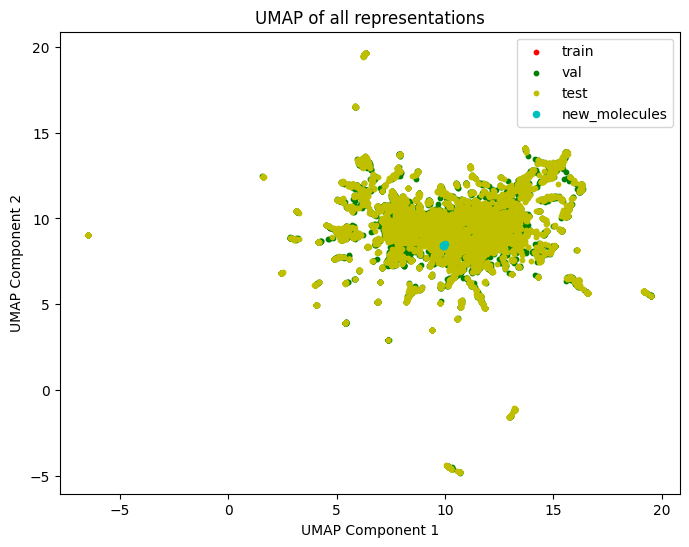

In [ ]:

plt.figure(figsize=(8, 6))
plt.scatter(x=X_umap[:train_checkpoint, 0], y=X_umap[:train_checkpoint, 1], c='r', s=10)
plt.scatter(x=X_umap[train_checkpoint:val_checkpoint, 0], y=X_umap[train_checkpoint:val_checkpoint, 1], c='g', s=10)
plt.scatter(x=X_umap[val_checkpoint:test_checkpoint, 0], y=X_umap[val_checkpoint:test_checkpoint, 1], c='y', s=10)
plt.scatter(x=X_umap[test_checkpoint:, 0], y=X_umap[test_checkpoint:, 1], c='c', s=20)

plt.legend(['train', 'val', 'test', 'new_molecules'])


plt.title('UMAP of all representations')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [ ]:
X_umap[-4:]

array([[ 9.923561,  8.449236],
       [ 9.966725,  8.401181],
       [10.024661,  8.48073 ],
       [ 9.894206,  8.376627]], dtype=float32)

In [ ]:
len(all_testset_tensors)

3881